In [1]:
import pandas as pd
import numpy as np
import fbprophet as fb
import glob
import os
import matplotlib, datetime
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot, plot_components

Importing plotly failed. Interactive plots will not work.


In [2]:
pd.options.display.max_columns = 999

### create list of files to read

In [3]:
actual_loads = glob.glob('NYISO Historical_Raw Data/Actual Load/*csv')

In [4]:
actual_loads[:2]

['NYISO Historical_Raw Data/Actual Load/OASIS_Real_Time_Weighted_Integrated_Actual_Load 2016 2.csv',
 'NYISO Historical_Raw Data/Actual Load/OASIS_Real_Time_Weighted_Integrated_Actual_Load 2014 1.csv']

In [5]:
actual_hard_path = 'NYISO Historical_Raw Data/Actual Load/OASIS_Real_Time_Weighted_Integrated_Actual_Load '
actuals = {}

### iterate through list, save just the unique parts of the file name, store in dictionary

In [6]:
for file in actual_loads:
    name = file.replace(actual_hard_path, '').replace(' ', '_').replace('.csv', '')
    actuals[name] = pd.read_csv(file)

In [7]:
actuals_df = pd.concat(actuals, axis=0)

In [8]:
actuals_df['ds'] = pd.to_datetime(actuals_df['Eastern Date Hour'])

In [9]:
actuals_df.head()

Eastern Date Hour Zone Name  Zone PTID  TWI Actual Load         ds
2016_2 0  2016/08/01 00:00:00    CAPITL      61757           1260.5 2016-08-01
       1  2016/08/01 00:00:00    CENTRL      61754           1665.6 2016-08-01
       2  2016/08/01 00:00:00    DUNWOD      61760            710.7 2016-08-01
       3  2016/08/01 00:00:00    GENESE      61753           1063.6 2016-08-01
       4  2016/08/01 00:00:00    HUD VL      61758           1066.3 2016-08-01

In [10]:
actuals_df['Zone Name'].value_counts()
# looks like the naming of zones is consistent

DUNWOD    22176
GENESE    22176
NORTH     22176
CAPITL    22176
HUD VL    22176
MILLWD    22176
N.Y.C.    22176
CENTRL    22176
MHK VL    22176
LONGIL    22176
WEST      22176
Name: Zone Name, dtype: int64

In [11]:
actuals_df.sort_values('ds', inplace = True)

In [12]:
actuals_df

Eastern Date Hour Zone Name  Zone PTID  TWI Actual Load  \
2009_1 10     2009/06/24 00:00:00      WEST      61752           1547.0   
       0      2009/06/24 00:00:00    CAPITL      61757           1088.3   
       1      2009/06/24 00:00:00    CENTRL      61754           1585.3   
       2      2009/06/24 00:00:00    DUNWOD      61760            590.9   
       3      2009/06/24 00:00:00    GENESE      61753            981.1   
...                           ...       ...        ...              ...   
2019_2 12138  2019/09/15 23:00:00    LONGIL      61762           2341.7   
       12139  2019/09/15 23:00:00    MHK VL      61756            733.4   
       12140  2019/09/15 23:00:00    MILLWD      61759            260.5   
       12142  2019/09/15 23:00:00     NORTH      61755            475.4   
       12143  2019/09/15 23:00:00      WEST      61752           1484.8   

                              ds  
2009_1 10    2009-06-24 00:00:00  
       0     2009-06-24 00:00:00  
       1     2009-06-24 00:00:00  
       2     2009-06-24 00:00:00  
       3     2009-06-24 00:00:00  
...                          ...  
2019_2 12138 2019-09-15 23:00:00  
       12139 2019-09-15 23:00:00  
       12140 2019-09-15 23:00:00  
       12142 2019-09-15 23:00:00  
       12143 2019-09-15 23:00:00  

[243936 rows x 5 columns]

In [13]:
def scatter_date(df, x, y, datetimeformat, **kwargs):
    if not isinstance(y, list):
        y = [y]
    for yi in y:
        plt.plot_date(df[x].apply(
            lambda z: matplotlib.dates.date2num(
                datetime.datetime.strptime(z, datetimeformat))), df[yi], label=yi, alpha=0.6)
    plt.legend()
    plt.xlabel(x)
    if kwargs.get('title'):
        plt.title(kwargs.get('title'))

In [14]:
actuals_df['ts_string'] = actuals_df['ds'].astype(str)

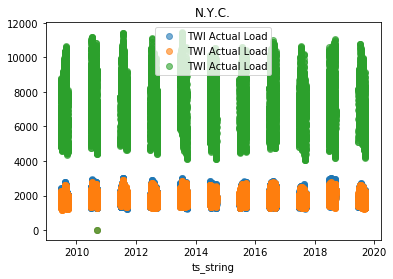

In [15]:
for zone in ['CENTRL', 'WEST', 'N.Y.C.']:
    scatter_date(actuals_df[actuals_df['Zone Name'] == zone], x='ts_string', y='TWI Actual Load', datetimeformat='%Y-%m-%d %H:%M:%S', title = zone)

In [16]:
actuals_df['ds'].dt.month.value_counts()

8    90024
7    90024
9    43560
6    20328
Name: ds, dtype: int64

In [17]:
sub_df = actuals_df[actuals_df['Zone Name'] == 'N.Y.C.']
#fbprophet requires the column names ds and y
sub_df.rename(columns = {'TWI Actual Load': 'y'}, inplace = True)

/Users/christopherlee/miniconda3/envs/cal/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [18]:
sub_df

Eastern Date Hour Zone Name  Zone PTID       y  \
2009_1 8      2009/06/24 00:00:00    N.Y.C.      61761  5531.1   
       19     2009/06/24 01:00:00    N.Y.C.      61761  5201.6   
       30     2009/06/24 02:00:00    N.Y.C.      61761  5001.6   
       41     2009/06/24 03:00:00    N.Y.C.      61761  4899.3   
       52     2009/06/24 04:00:00    N.Y.C.      61761  4908.6   
...                           ...       ...        ...     ...   
2019_2 12097  2019/09/15 19:00:00    N.Y.C.      61761  6691.5   
       12108  2019/09/15 20:00:00    N.Y.C.      61761  6682.4   
       12119  2019/09/15 21:00:00    N.Y.C.      61761  6560.6   
       12130  2019/09/15 22:00:00    N.Y.C.      61761  6300.5   
       12141  2019/09/15 23:00:00    N.Y.C.      61761  5931.7   

                              ds            ts_string  
2009_1 8     2009-06-24 00:00:00  2009-06-24 00:00:00  
       19    2009-06-24 01:00:00  2009-06-24 01:00:00  
       30    2009-06-24 02:00:00  2009-06-24 02:00:00  
       41    2009-06-24 03:00:00  2009-06-24 03:00:00  
       52    2009-06-24 04:00:00  2009-06-24 04:00:00  
...                          ...                  ...  
2019_2 12097 2019-09-15 19:00:00  2019-09-15 19:00:00  
       12108 2019-09-15 20:00:00  2019-09-15 20:00:00  
       12119 2019-09-15 21:00:00  2019-09-15 21:00:00  
       12130 2019-09-15 22:00:00  2019-09-15 22:00:00  
       12141 2019-09-15 23:00:00  2019-09-15 23:00:00  

[22176 rows x 6 columns]

In [19]:
m = fb.Prophet()

In [20]:
m.add_country_holidays('US')

In [21]:
m.fit(sub_df)

In [22]:
training = m.predict(sub_df)

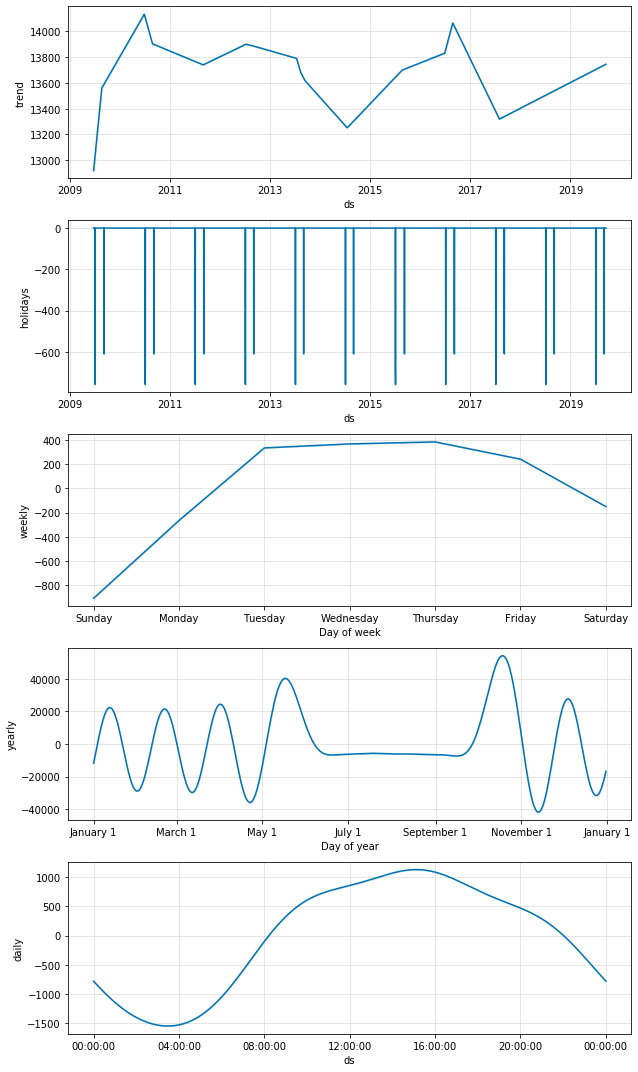

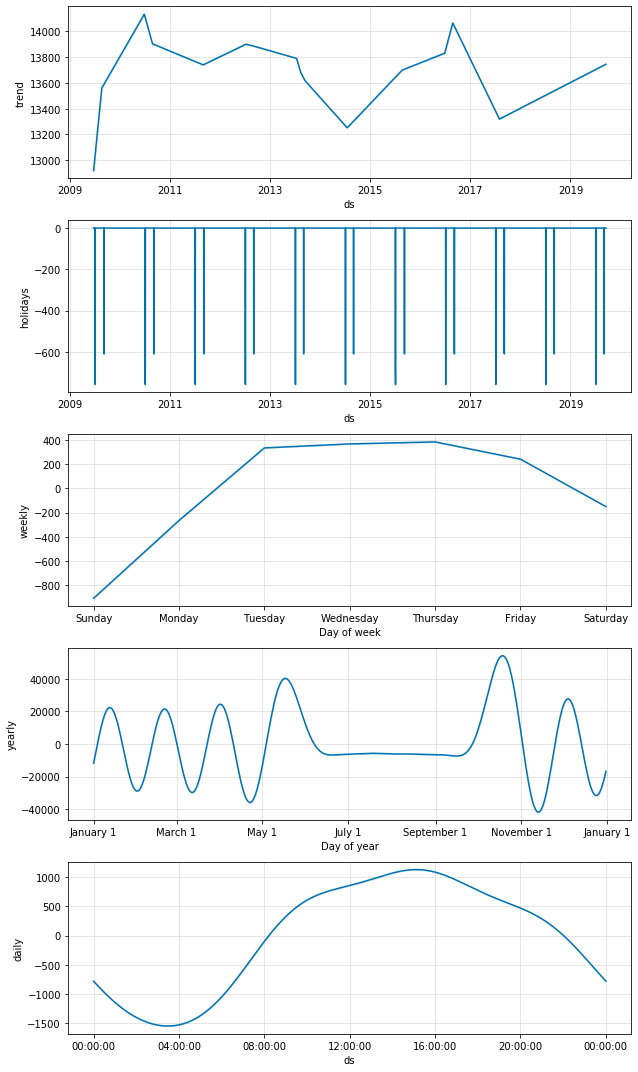

In [23]:
m.plot_components(training)

In [24]:
training['Independence Day'].value_counts()

 0.0000      21912
-757.0708      264
Name: Independence Day, dtype: int64

In [25]:
training['Labor Day'].value_counts()

 0.000000      21912
-608.621559      264
Name: Labor Day, dtype: int64

In [26]:
future_df = m.make_future_dataframe(periods = 365)

### need to filter out the months we don't have

In [27]:
future_df['ds'].dt.month.value_counts()

8     8215
7     8215
9     3989
6     1878
12      31
10      31
5       31
3       31
1       31
11      30
4       30
2       29
Name: ds, dtype: int64

In [28]:
sub_df[sub_df['ds'].dt.year == 2019]['ds'].min()

Timestamp('2019-06-24 00:00:00')

In [29]:
sub_df['ds'].min()

Timestamp('2009-06-24 00:00:00')

In [30]:
sub_df['ds'].dt.dayofyear

2009_1  8        175
        19       175
        30       175
        41       175
        52       175
                ... 
2019_2  12097    258
        12108    258
        12119    258
        12130    258
        12141    258
Name: ds, Length: 22176, dtype: int64

In [31]:
sub_df['ds'].max()

Timestamp('2019-09-15 23:00:00')

In [32]:
future_df = future_df[(future_df['ds'].dt.dayofyear >= 175) & (future_df['ds'].dt.dayofyear <= 258)]

In [33]:
prediction = m.predict(future_df)

In [34]:
### Prediction plot

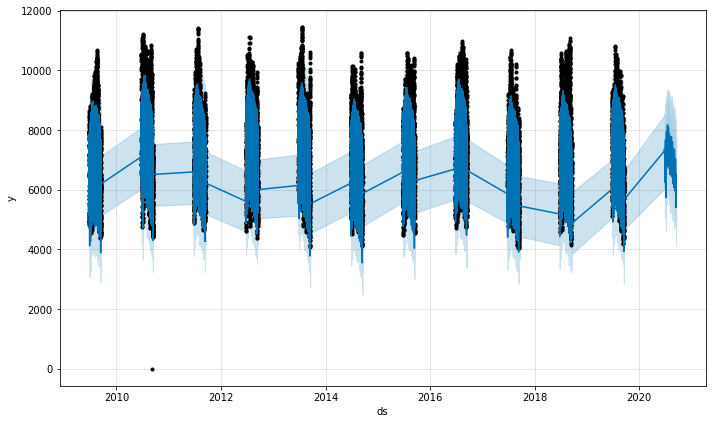

In [35]:
nyc_plot = m.plot(prediction)

In [36]:
prediction[['ds', 'yhat']]

,ds,yhat
0,2009-06-24 00:00:00,5894.865602
1,2009-06-24 01:00:00,5540.390339
2,2009-06-24 02:00:00,5291.118433
3,2009-06-24 03:00:00,5167.754013
4,2009-06-24 04:00:00,5179.251278
...,...,...
22207,2020-09-10 23:00:00,6725.723378
22208,2020-09-11 23:00:00,6269.516721
22209,2020-09-12 23:00:00,5398.230827
22210,2020-09-13 23:00:00,5915.105811
